In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.model_selection import train_test_split

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../Dữ liệu Lịch sử HSG.csv')
df['Ngày']=pd.to_datetime(df.Ngày, format ="%d/%m/%Y")
  # Sort the dataframe by date in ascending order
df = df.sort_values('Ngày')

In [3]:
# Rename columns
df.rename(columns={"Ngày":"Date","Lần cuối":"Close","Mở":"Open","Cao":"High","Thấp":"Low","KL": "Volume","% Thay đổi": "percent_change"}, inplace= True)


In [4]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%d/%m/%Y')
  df['Close'] = df['Close'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Volume'] = df['Volume'].apply(convert_to_number)
  df['percent_change'] = df['percent_change'].apply(lambda x: float(x.strip('%'))/100)

In [5]:
df

,Date,Close,Open,High,Low,Volume,percent_change
1348,2017-12-01,13830.5,13772.9,13917.0,13657.6,4.41M,0.84%
1347,2017-12-04,14781.4,14061.0,14781.4,13830.5,13.71M,6.88%
1346,2017-12-05,14522.1,15040.7,15242.4,14522.1,12.28M,-1.75%
1345,2017-12-06,14896.6,14464.4,15069.5,14320.4,9.47M,2.58%
1344,2017-12-07,14666.1,15098.3,15184.8,14550.9,5.52M,-1.55%
...,...,...,...,...,...,...,...
4,2023-04-24,14600.0,14900.0,15050.0,14400.0,8.29M,-2.34%
3,2023-04-25,14950.0,14700.0,15200.0,14700.0,6.78M,2.40%
2,2023-04-26,15700.0,14950.0,15700.0,14800.0,13.61M,5.02%
1,2023-04-27,15300.0,15750.0,15800.0,15250.0,10.65M,-2.55%


In [6]:
tranformData(df)

In [7]:
#Định dạng lại cột Date từ obj -> datetime
df['Date'] = pd.to_datetime(df['Date'])
# Chuyển cột Date làm index để lập biểu đồ so sánh về sau
df.index = df.Date
df.drop('Date', axis=1, inplace=True)

In [8]:
df

,Close,Open,High,Low,Volume,percent_change
Date,,,,,,
2017-12-01,13830.5,13772.9,13917.0,13657.6,4410000.0,0.0084
2017-12-04,14781.4,14061.0,14781.4,13830.5,13710000.0,0.0688
2017-12-05,14522.1,15040.7,15242.4,14522.1,12280000.0,-0.0175
2017-12-06,14896.6,14464.4,15069.5,14320.4,9470000.0,0.0258
2017-12-07,14666.1,15098.3,15184.8,14550.9,5520000.0,-0.0155
...,...,...,...,...,...,...
2023-04-24,14600.0,14900.0,15050.0,14400.0,8290000.0,-0.0234
2023-04-25,14950.0,14700.0,15200.0,14700.0,6780000.0,0.0240
2023-04-26,15700.0,14950.0,15700.0,14800.0,13610000.0,0.0502


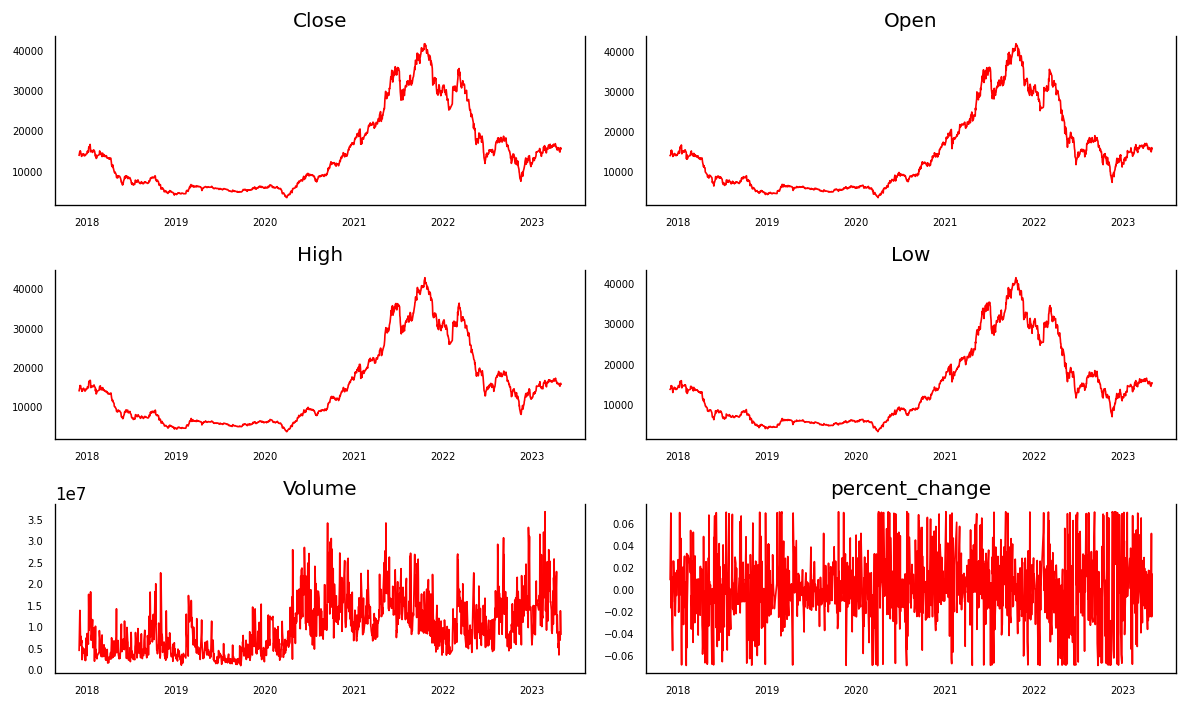

In [9]:


# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
     

In [10]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Close_x,Open_x,High_x,Low_x,Volume_x,percent_change_x
Close_y,1.0000,0.0001,0.0006,0.0000,0.0001,0.0134
Open_y,0.0000,1.0000,0.0000,0.0000,0.0001,0.0000
High_y,0.0000,0.0000,1.0000,0.0000,0.0035,0.0000
Low_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
Volume_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
percent_change_y,0.1443,0.3751,0.0354,0.3596,0.0065,1.0000


In [11]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Close  ::  685.68    > 83.9383   =>   True
Open   ::  455.78    > 60.0627   =>   True
High   ::  251.5     > 40.1749   =>   True
Low    ::  98.84     > 24.2761   =>   True
Volume ::  28.74     > 12.3212   =>   True
percent_change ::  0.46      > 4.1296    =>   False


In [12]:
nobs=int(0.2*len(df))
n_train = int(0.6 * len(df))
n_test = int(0.2 * len(df))
n_validation = len(df) - n_train - n_test
nobs_val= n_validation
df_train = df[:n_train]
df_test = df[n_train:n_train+n_test]
df_validation = df[n_train+n_test:]

# Kiểm tra kích thước
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)

(809, 6)
(269, 6)
(271, 6)


In [13]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [14]:
# ADF Test on each column
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.6468
 No. Lags Chosen       = 8
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.9887. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.728
 No. Lags Chosen       = 17
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.9904. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit roo

In [15]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [16]:
# ADF Test trên từng cột của DataFrame chứa sự khác biệt đầu tiên
for name in df_differenced.columns:
    adfuller_test(df_differenced[name], name=name)
    print('\n')


    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.0327
 No. Lags Chosen       = 7
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.322
 No. Lags Chosen       = 16
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [17]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [18]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close"

 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.1016
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.2755
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.1297
 No.

In [19]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  66.56841668189318
BIC :  66.81291732356226
FPE :  8.133868970296526e+28
HQIC:  66.66230964087217 

Lag Order = 2
AIC :  64.83604740549971
BIC :  65.29056380008188
FPE :  1.438616158545879e+28
HQIC:  65.01060070199568 

Lag Order = 3
AIC :  63.80887371097929
BIC :  64.4738168909375
FPE :  5.150681355461108e+27
HQIC:  64.06425468821934 

Lag Order = 4
AIC :  63.13820585569843
BIC :  64.01398818084415
FPE :  2.634067218017789e+27
HQIC:  63.47458241052348 

Lag Order = 5
AIC :  62.59453100694016
BIC :  63.681566170360576
FPE :  1.5295364394113673e+27
HQIC:  63.0120715923078 

Lag Order = 6
AIC :  62.31026764436181
BIC :  63.60897067838076
FPE :  1.1512690841113407e+27
HQIC:  62.80914127186346 

Lag Order = 7
AIC :  62.066811217716086
BIC :  63.57759849988899
FPE :  9.02700849388127e+26
HQIC:  62.647187460108654 

Lag Order = 8
AIC :  61.78690264640287
BIC :  63.51019190554591
FPE :  6.825153995448307e+26
HQIC:  62.44895164015491 

Lag Order = 9
AIC :  61.50678475954561

In [20]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,70.39,70.43,3.718e+30,70.40
1,66.57,66.82,8.161e+28,66.67
2,64.84,65.30,1.440e+28,65.01
3,63.81,64.48,5.131e+27,64.07
4,63.13,64.02,2.614e+27,63.47
5,62.62,63.72,1.562e+27,63.04
6,62.32,63.64,1.166e+27,62.83
7,62.09,63.62,9.204e+26,62.67
8,61.80,63.54,6.915e+26,62.47
9,61.54,63.49*,5.319e+26,62.29


In [61]:
model_fitted = model.fit(40)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, Jun, 2023
Time:                     23:17:35
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    68.9700
Nobs:                     767.000    HQIC:                   63.5866
Log likelihood:          -28177.4    FPE:                1.62011e+26
AIC:                      60.2177    Det(Omega_mle):     3.14451e+25
--------------------------------------------------------------------
Results for equation Close
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      3.553224         8.562776            0.415           0.678
L1.Close                  -0.972909         0.150573           -6.461           0.000
L1.Open                    0.360856     

In [62]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

40


array([[ 3.7900e+01,  2.2720e+02,  7.5800e+01, -1.5150e+02,  4.8000e+05,
         1.1300e-02],
       [ 4.5450e+02, -1.8940e+02,  4.1660e+02,  1.1360e+02,  3.6600e+06,
         2.5300e-02],
       [ 8.7120e+02,  1.1743e+03,  1.0227e+03,  8.3340e+02,  3.7100e+06,
         2.4100e-02],
       [-1.0984e+03, -2.2730e+02, -4.9230e+02, -3.8000e+01, -9.5100e+06,
        -1.1740e-01],
       [-1.5160e+02, -4.1670e+02, -9.4710e+02, -7.9530e+02,  3.7900e+06,
         5.7400e-02],
       [ 3.7890e+02, -7.1970e+02,  3.7880e+02, -3.8000e+01,  1.3500e+06,
         2.9500e-02],
       [-3.0310e+02,  6.4400e+02,  7.5800e+01,  1.8940e+02, -9.0000e+05,
        -3.8000e-02],
       [ 0.0000e+00, -3.7900e+01, -3.4090e+02,  1.0000e-01, -4.1000e+06,
         1.6900e-02],
       [ 7.5750e+02, -3.0300e+02,  7.9550e+02,  7.5700e+01,  1.0010e+07,
         4.1500e-02],
       [-6.4380e+02,  1.1742e+03, -4.9250e+02,  3.7880e+02, -1.0860e+07,
        -7.7000e-02],
       [-2.6520e+02, -1.2500e+03, -3.0300e+02, -5.

In [63]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[n_train:n_train+n_test], columns=df.columns + '_2d')
df_forecast

,Close_2d,Open_2d,High_2d,Low_2d,Volume_2d,percent_change_2d
Date,,,,,,
2021-03-04,525.420802,1435.219181,841.182926,732.681703,-2.959111e+06,0.079445
2021-03-05,-573.710814,-623.586178,-640.411150,-1077.987499,1.378406e+07,-0.138059
2021-03-08,487.987738,-966.543382,96.809061,428.236827,-1.269407e+07,0.046198
2021-03-09,-383.549775,1784.741116,169.653115,1313.162701,-2.645509e+06,-0.053069
2021-03-10,-314.456708,-1268.989001,-635.821271,-1468.319264,5.381425e+05,0.075917
...,...,...,...,...,...,...
2022-03-24,91.195823,59.243672,-19.972089,-16.935327,1.093844e+06,0.002942
2022-03-25,113.213605,46.611030,137.116963,67.065972,1.721036e+06,0.011685
2022-03-28,81.882377,102.648302,-68.750023,371.268712,-4.939664e+06,-0.007440


In [64]:
# Forecast val
fc_val = model_fitted.forecast(y=forecast_input, steps=nobs_val)
df_forecast_val = pd.DataFrame(fc_val, index=df.index[n_train+n_test:], columns=df.columns + '_2d')
df_forecast_val

,Close_2d,Open_2d,High_2d,Low_2d,Volume_2d,percent_change_2d
Date,,,,,,
2022-03-31,525.420802,1435.219181,841.182926,732.681703,-2.959111e+06,0.079445
2022-04-01,-573.710814,-623.586178,-640.411150,-1077.987499,1.378406e+07,-0.138059
2022-04-04,487.987738,-966.543382,96.809061,428.236827,-1.269407e+07,0.046198
2022-04-05,-383.549775,1784.741116,169.653115,1313.162701,-2.645509e+06,-0.053069
2022-04-06,-314.456708,-1268.989001,-635.821271,-1468.319264,5.381425e+05,0.075917
...,...,...,...,...,...,...
2023-04-24,81.882377,102.648302,-68.750023,371.268712,-4.939664e+06,-0.007440
2023-04-25,-247.240710,-46.213591,105.323694,-286.331124,3.673343e+06,-0.024067
2023-04-26,-34.082591,-184.495185,-251.343817,-172.419103,-1.820840e+06,0.027227


In [65]:
def invert_transformation(df_train, df_forecast_val, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc_val = df_forecast_val.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc_val[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc_val[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc_val[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc_val[str(col)+'_1d'].cumsum()
    return df_fc_val

In [66]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [67]:
df_results_val = invert_transformation(df_train, df_forecast_val, second_diff=True)        
df_results_val.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Volume_forecast', 'percent_change_forecast']]

,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
Date,,,,,,
2022-03-31,21964.820802,22117.119181,22469.982926,21641.681703,1.124089e+07,0.097445
2022-04-01,22068.030790,22512.152184,22708.654702,21220.575908,2.172584e+07,0.049630
2022-04-04,22659.228515,21940.641805,23044.135539,21227.706939,1.951672e+07,0.048013
2022-04-05,22866.876465,23153.872542,23549.269491,22548.000671,1.466210e+07,-0.006673
2022-04-06,22760.067707,23098.114278,23418.582172,22399.975139,1.034561e+07,0.014558
...,...,...,...,...,...,...
2023-04-24,86515.384911,86955.164213,88370.915501,84506.134218,1.111522e+08,-0.091416
2023-04-25,86709.011741,87297.224921,88762.959747,84803.870795,1.125584e+08,-0.112392
2023-04-26,86868.555980,87454.790445,88903.660175,84929.188269,1.121439e+08,-0.106141


In [68]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Volume_forecast', 'percent_change_forecast']]

,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
Date,,,,,,
2021-03-04,21964.820802,22117.119181,22469.982926,21641.681703,1.124089e+07,0.097445
2021-03-05,22068.030790,22512.152184,22708.654702,21220.575908,2.172584e+07,0.049630
2021-03-08,22659.228515,21940.641805,23044.135539,21227.706939,1.951672e+07,0.048013
2021-03-09,22866.876465,23153.872542,23549.269491,22548.000671,1.466210e+07,-0.006673
2021-03-10,22760.067707,23098.114278,23418.582172,22399.975139,1.034561e+07,0.014558
...,...,...,...,...,...,...
2022-03-24,85715.532208,86281.263915,87728.724374,83709.267527,1.107466e+08,-0.105039
2022-03-25,86074.517371,86566.889913,88084.194949,83922.066516,1.134192e+08,-0.094508
2022-03-28,86515.384911,86955.164213,88370.915501,84506.134218,1.111522e+08,-0.091416


In [69]:
# Chuyển đổi dự đoán về đơn vị ban đầu
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to the original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col) + '_1d'] = (df_train[col].iloc[-1] - df_train[col].iloc[-2]) + df_fc[col + '_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[col + '_1d'].cumsum()
    return df_fc

df_future_results = invert_transformation(df_train, df_future, second_diff=True)
df_future_results.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast', 'Volume_forecast', 'percent_change_forecast']]


,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
0,21964.820802,22117.119181,22469.982926,21641.681703,1.124089e+07,0.097445
1,22068.030790,22512.152184,22708.654702,21220.575908,2.172584e+07,0.049630
2,22659.228515,21940.641805,23044.135539,21227.706939,1.951672e+07,0.048013
3,22866.876465,23153.872542,23549.269491,22548.000671,1.466210e+07,-0.006673
4,22760.067707,23098.114278,23418.582172,22399.975139,1.034561e+07,0.014558
...,...,...,...,...,...,...
264,85715.532208,86281.263915,87728.724374,83709.267527,1.107466e+08,-0.105039
265,86074.517371,86566.889913,88084.194949,83922.066516,1.134192e+08,-0.094508
266,86515.384911,86955.164213,88370.915501,84506.134218,1.111522e+08,-0.091416
267,86709.011741,87297.224921,88762.959747,84803.870795,1.125584e+08,-0.112392


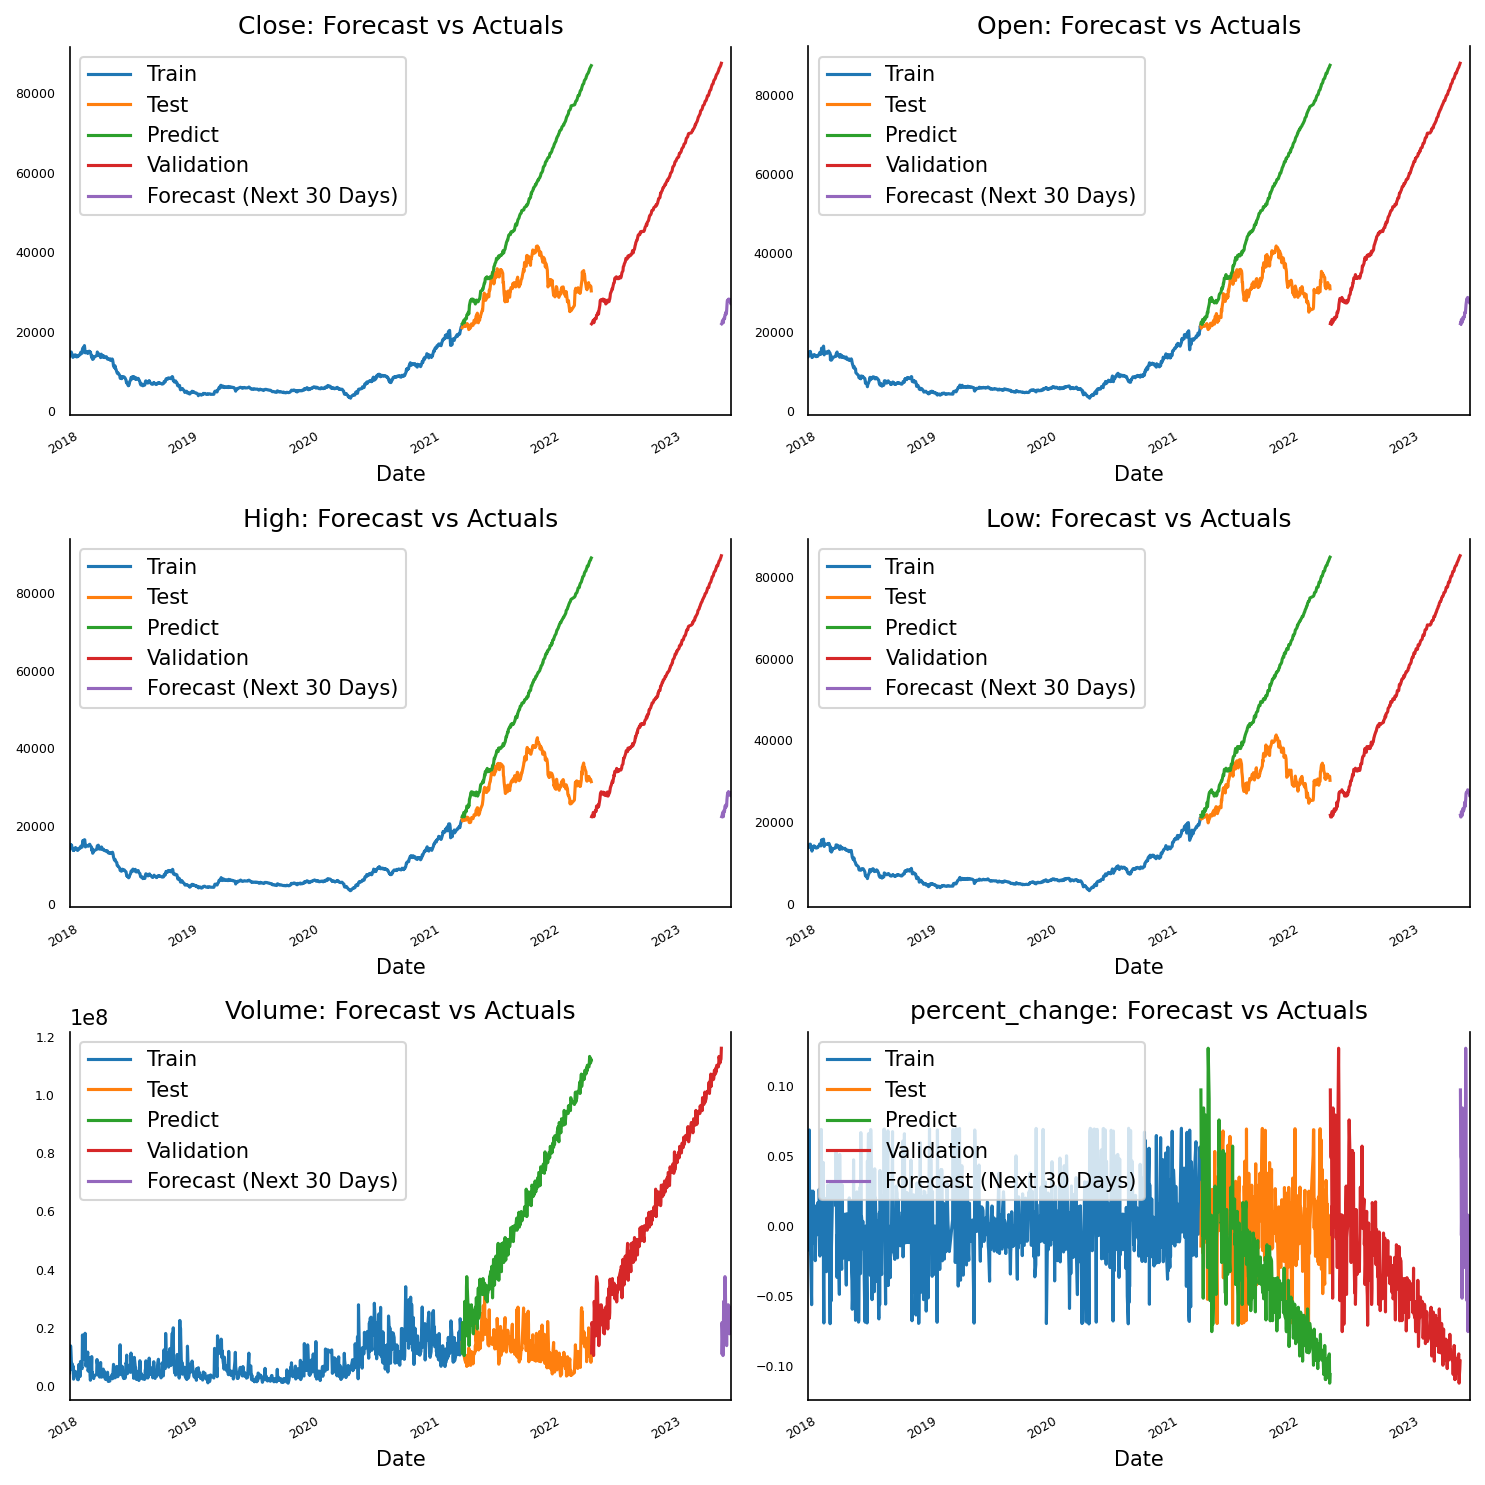

In [70]:
import datetime

# Sử dụng model_fitted để dự đoán 30 ngày tiếp theo
n_forecast_days = 30
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)

# Chuyển đổi dự đoán thành DataFrame
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

# Chuyển đổi dự đoán về đơn vị ban đầu
df_future_results = invert_transformation(df_train, df_future, second_diff=True)

# Tạo index cho 30 ngày tiếp theo
future_dates = pd.date_range(start=df.index[-1] + datetime.timedelta(days=1), periods=n_forecast_days, freq='D')

# Tạo DataFrame chứa dự đoán cho 30 ngày tiếp theo
df_future_forecast = pd.DataFrame(df_future_results.values, index=future_dates, columns=df_future_results.columns)

# Vẽ đồ thị
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
    df_train[col].plot(legend=True, ax=ax, label='Train')
    df_test[col][-nobs:].plot(legend=True, ax=ax, label='Test')
    df_results[col+'_forecast'].plot(legend=True, ax=ax, label='Predict').autoscale(axis='x', tight=True)
    df_results_val[col+'_forecast'].plot(legend=True, ax=ax, label='Validation').autoscale(axis='x', tight=True)
    df_future_forecast[col + '_forecast'].plot(legend=True, ax=ax, label='Forecast (Next 30 Days)')
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()
